# Project Details:
- This is the main source code for the Group Cooursework of Group 16 for Big Data 1 in RMFE at Imperial College London.
- The Project tackled the problem of predicting the change in Electricity Prices.
- This Project is a competition sponsored by Qube Research Technologies.
- The Details of the competition can be found here: https://challengedata.ens.fr/participants/challenges/97/
- 6 Machine Learning Models were used and tested on Out of Sample Data. 
- The Best Performance was by a LightGBM Model that resulted with a Score Metric of 27.49% Spearman Rank Correlation. 
- This Score put the team's position at 77 out of total global submissions of 866 individuals and teams. 


  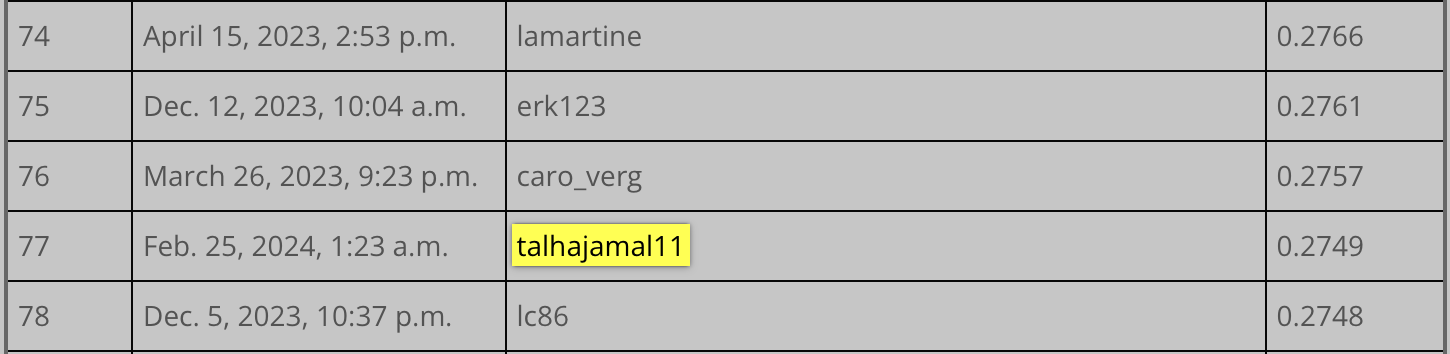

# Import Packages

In [1]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Plotting and Metric Score

In [2]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()


def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

def plot_ts_y(ts_x, ts_y, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, label=ts_x)
    plt.plot(ts_y, label=ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

# Data Preprocessing

In [3]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv")#.set_index('ID').sort_values(by='DAY_ID')
y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv")#.set_index('ID')
x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv")#.set_index('ID')

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
x_validation.head()

In [ ]:
# Do we have a Data Tilt
X['COUNTRY'].value_counts()

# Missing Data

In [ ]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Fill Data

In [ ]:
X.interpolate(method='polynomial',order=3, inplace=True)
X = X.fillna(0)
X = X.drop(['COUNTRY'], axis=1)

x_validation.interpolate(method='polynomial',order=3, inplace=True)
x_validation = x_validation.fillna(0)
x_validation = x_validation.drop(['COUNTRY'], axis=1)

In [ ]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Feature Engineering

In [ ]:
correlation = [metric_train(X[col], y['TARGET']) for col in X.columns]
correlation_df = pd.DataFrame(correlation, index=X.columns, columns=['Features'])
plt.figure(figsize=(10, 5))
correlation_df.sort_values(by='Features').plot(kind='bar', figsize=(10,5))
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
low_corr = correlation_df[abs(correlation_df['Features']) < 2.5]
low_corr

In [ ]:
columns_to_keep = ['COUNTRY_DE', 'COUNTRY_FR']
columns_to_drop = [column for column in low_corr.index if column not in columns_to_keep]
X_dropped = X.drop(columns=columns_to_drop)

In [ ]:
new_correlation = [metric_train(X_dropped[col], y['TARGET']) for col in X_dropped.columns]
new_correlation_df = pd.DataFrame(new_correlation, index=X_dropped.columns, columns=['Features'])
plt.figure(figsize=(10, 5))
new_correlation_df.sort_values(by='Features').plot(kind='bar', figsize=(10,5))
plt.title('Correlation of Relevant Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
new_correlation_df.sort_values(by='Features', inplace=True)
new_correlation_df

### Plot of every feature against TARGET

In [ ]:
X_plot = X.copy(deep=True)
#X_plot = X_plot.sort_index()
y_plot = y.copy(deep=True)
#y_plot = y_plot.sort_index()
# Plot all data to find patterns
for col in X_plot.columns:
    if col == 'DAY_ID' or col == 'ID':
        continue
    plot_ts_y(X_plot[col], y_plot['TARGET'], title=col)

# Cross Validation for MSE using XGBRegressor

In [ ]:
def XGBRegressorCrossValidationMSE(X_clean, Y_clean):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 6, 10],  # LightGBM's 'num_leaves' can be roughly translated to 'max_depth' in XGBoost
        'reg_alpha': [0.1, 0.2, 0.3],  # LightGBM's 'bagging_fraction' does not have a direct equivalent, but 'reg_alpha' can help with regularization
        'n_estimators': [100],  # Reduced number of options for 'n_estimators' to speed up the process
        'learning_rate': [0.05, 0.1, 0.2],  # Same as LightGBM's
        'colsample_bytree': [0.6, 0.8, 0.9],  # Similar to LightGBM's 'feature_fraction'
        'subsample': [0.6, 0.8, 0.9]  # Similar to LightGBM's 'bagging_fraction'
    }

    # Initialize the XGBRegressor
    xgb_reg = XGBRegressor(booster='gbtree', objective='reg:squarederror')
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
        verbose=2
    )

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Results
    best_parameters = grid_search.best_params_
    best_mse = -1 * grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = 100 * spearmanr(y_pred_train, y_train).correlation
    y_pred_test = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Output the best parameters and corresponding mean square error
    print("Best parameters found: ", grid_search.best_params_)
    print("Best MSE: ", best_mse)
    print("Spearman correlation on training data: ", spearman_corr)
    print("MSE on test data: ", mse_test)

    # Prepare the result dictionary
    result = {
        "model": best_model,
        "best_parameters": best_parameters,
        "best_mse": best_mse,
        "mse_test": mse_test,
        "spearman_correlation_train": spearman_corr
    }

    return result


# LightGBM model

In [ ]:
def LGBRegressorCrossValidationMSE(X_clean, Y_clean):

    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # define parameter space
    param_grid = {
        'num_leaves': [15, 31, 50],
        'learning_rate': [0.05, 0.1, 0.2],
        'feature_fraction': [0.6, 0.8, 0.9],
        'bagging_fraction': [0.6, 0.8, 0.9],
        'bagging_freq': [3, 5, 7]
    }

    # build the LightGBM model
    lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mse')
    # build the GridSearchCV on LightGBM
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    # grid search
    grid_search.fit(X_train, y_train)
    
    # results
    best_parameters = grid_search.best_params_
    best_mse = -1 * grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = spearmanr(y_pred_train, y_train).correlation * 100
    # calculate the target test data
    y_pred_test = best_model.predict(X_test)
    # Calculate MSE for test data
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Print Results
    print("Best parameters found: ", best_parameters)
    print("Best mse: ", best_mse)
    print("Best Spearman correlation:", spearman_corr)
    print("MSE on test data: ", mse_test)

    result = {
        "parameters": best_parameters,
        "model":best_model,
        "Best MSE": best_mse,
        "Test MSE":mse_test,
        "Metric Score": spearman_corr
    }
    return result

# Random Forest Model

In [ ]:
def RandomForestRegressorCrossValidationMSE(X_clean, Y_clean):
    """ Return the Cross Validated Parameters for RandomForestRegressor for MSE"""
    
    # X_clean and Y_clean must be processed already
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_reg = RandomForestRegressor(random_state=42)

    # GridSearchCV with the scoring minimizing MSE
    cv_method = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5,
                             scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    cv_method.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", cv_method.best_params_)

    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)

    # Calculate MSE on the test set and then convert to RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))

    training_prediction = cv_method.predict(X_clean)

    print('Cross Validated Model MSE for the train set: {:.2f}'.format(mean_squared_error(training_prediction, Y_clean)))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction": training_prediction,
        "Metric Score": mean_squared_error(training_prediction, Y_clean),
        "model": cv_method
    }
    return result


# Lasso Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.linear_model import LassoCV, RidgeCV

X_train_raw = pd.read_csv(r"/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/data/X_train_NHkHMNU.csv")
y_train_raw = pd.read_csv(r"/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/data/y_train_ZAN5mwg.csv")
X_train_raw = X_train_raw.fillna(method="ffill").fillna(method="bfill")
X_train_raw = pd.get_dummies(X_train_raw, columns=["COUNTRY"])
X_train_raw["FR"] = X_train_raw["COUNTRY_FR"].astype(int)
X_train_raw = X_train_raw.sort_values(by=["DAY_ID", "FR"], ascending=[True, True])
X_train_raw["DE_NET_NET_EXPORT"] = X_train_raw["DE_NET_EXPORT"] - X_train_raw["DE_NET_IMPORT"]
X_train_raw["FR_NET_NET_EXPORT"] = X_train_raw["FR_NET_EXPORT"] - X_train_raw["FR_NET_IMPORT"]
X_train_adjusted = pd.merge(X_train_raw, y_train_raw, on="ID", how="left")
X, y = X_train_adjusted.drop(["ID", "TARGET", "DAY_ID", "COUNTRY_FR", "COUNTRY_DE", "DE_FR_EXCHANGE", "DE_NET_EXPORT", "DE_NET_IMPORT", "FR_NET_EXPORT", "FR_NET_IMPORT"], axis=1), X_train_adjusted["TARGET"]
print(X.head())

X_test_target = pd.read_csv(r"/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/data/X_test_final.csv")
X_test_target = X_test_target.fillna(method="ffill").fillna(method="bfill")
X_test_target = pd.get_dummies(X_test_target, columns=["COUNTRY"])
X_test_target["FR"] = X_test_target["COUNTRY_FR"].astype(int)
X_test_target["DE_NET_NET_EXPORT"] = X_test_target["DE_NET_EXPORT"] - X_test_target["DE_NET_IMPORT"]
X_test_target["FR_NET_NET_EXPORT"] = X_test_target["FR_NET_EXPORT"] - X_test_target["FR_NET_IMPORT"]
X_test_ID = X_test_target[["ID"]]
X_test_target = X_test_target.drop(["ID", "DAY_ID", "COUNTRY_FR", "COUNTRY_DE", "DE_FR_EXCHANGE", "DE_NET_EXPORT", "DE_NET_IMPORT", "FR_NET_EXPORT", "FR_NET_IMPORT"], axis=1)
print(X_test_target.head())

#Standardisation
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test_target_std = pd.DataFrame(scaler.transform(X_test_target), columns=X_test_target.columns)

#Principal Component Analysis
pca = PCA()
X_std_pca = pd.DataFrame(pca.fit_transform(X_std), columns=X_std.columns)
X_test_target_std_pca = pd.DataFrame(pca.transform(X_test_target_std), columns=X_test_target_std.columns)


#Lasso regression with time-series cross-validation
lasso_cv_t = LassoCV(cv=TimeSeriesSplit(n_splits=5), max_iter=10000).fit(X_std_pca, y)
print(f"Alpha: {lasso_cv_t.alpha_}")
#print(f"Coefficients: {lasso_cv_t.coef_}")

#Lasso regression with shuffled normal cross-validation
lasso_cv_ks = LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=9), max_iter=10000, random_state=9).fit(X_std_pca, y)
print(f"Alpha: {lasso_cv_ks.alpha_}")
#print(f"Coefficients: {lasso_cv_ks.coef_}")

#Lasso predictions
lasso_predict_t = lasso_cv_t.predict(X_test_target_std_pca)
lasso_predict_t_df = pd.DataFrame(lasso_predict_t, columns=["TARGET"])
lasso_predict_t_df["ID"] = X_test_ID["ID"]
lasso_predict_t_df = lasso_predict_t_df[["ID", "TARGET"]]
lasso_predict_t_df.to_csv("submission_files/lasso_predict_t.csv", index=False)

lasso_predict_ks = lasso_cv_ks.predict(X_test_target_std_pca)
lasso_predict_ks_df = pd.DataFrame(lasso_predict_ks, columns=["TARGET"])
lasso_predict_ks_df["ID"] = X_test_ID["ID"]
lasso_predict_ks_df = lasso_predict_ks_df[["ID", "TARGET"]]
lasso_predict_ks_df.to_csv("submission_files/lasso_predict_ks.csv", index=False)


#Ridge regression with time-series cross-validation
ridge_cv_t = RidgeCV(cv=TimeSeriesSplit(n_splits=5), scoring="neg_mean_squared_error").fit(X_std, y)
print(f"Alpha: {ridge_cv_t.alpha_}")
#print(f"Coefficients: {ridge_cv_t.coef_}")

#Ridge regression with shuffled normal cross-validation
ridge_cv_ks = RidgeCV(cv=KFold(n_splits=5, shuffle=True, random_state=9), scoring="neg_mean_squared_error").fit(X_std, y)
print(f"Alpha: {ridge_cv_ks.alpha_}")
#print(f"Coefficients: {ridge_cv_ks.coef_}")

#Ridge predictions
ridge_predict_t = ridge_cv_t.predict(X_test_target_std)
ridge_predict_t_df = pd.DataFrame(ridge_predict_t, columns=["TARGET"])
ridge_predict_t_df["ID"] = X_test_ID["ID"]
ridge_predict_t_df = ridge_predict_t_df[["ID", "TARGET"]]
ridge_predict_t_df.to_csv("submission_files/ridge_predict_t.csv", index=False)

ridge_predict_ks = ridge_cv_ks.predict(X_test_target_std)
ridge_predict_ks_df = pd.DataFrame(ridge_predict_ks, columns=["TARGET"])
ridge_predict_ks_df["ID"] = X_test_ID["ID"]
ridge_predict_ks_df = ridge_predict_ks_df[["ID", "TARGET"]]
ridge_predict_ks_df.to_csv("submission_files/ridge_predict_ks.csv", index=False)

# Running the Models

In [ ]:
X_clean = X.iloc[:, 2:] # X_clean should not have the ID column
#X_clean = X_dropped
Y_clean = y['TARGET']

# Running the Light GBM Model 

In [ ]:
CV_LGBM = LGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

In [ ]:
# Running the LightGBM Model
light_gbm_submission = x_validation[['ID']].copy()
X_validation_clean = x_validation.iloc[:, 2:]
light_gbm_submission['TARGET'] = CV_LGBM['model'].predict(X_validation_clean)
light_gbm_submission.to_csv('submission_files/light_gbm_submission.csv', index=False)

In [ ]:
lgbm_feature_importances = CV_LGBM['model'].feature_importances_
lgbm_importances = pd.Series(lgbm_feature_importances, index=X_clean.columns)
lgbm_importances = lgbm_importances.sort_values()
lgbm_importances.plot(kind='bar', figsize=(10,5))
plt.title('Feature Importance for Light GBM Model')
plt.show()

# Running the XGBoost Regression

In [ ]:
CV_XGB = XGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}

In [ ]:
# Running the XGB Model
xgb_submission = x_validation[['ID']].copy()
X_validation_clean = x_validation.iloc[:, 2:]
xgb_submission['TARGET'] = CV_XGB['model'].predict(X_validation_clean)
xgb_submission.to_csv('submission_files/xgb_submission.csv', index=False)

In [ ]:
xgb_feature_importances = CV_XGB['model'].feature_importances_
xgb_importances = pd.Series(xgb_feature_importances, index=X_clean.columns)
xgb_importances = xgb_importances.sort_values()
xgb_importances.plot(kind='bar', figsize=(10,3))
plt.title('Feature Importance for XGB Model')
plt.show()

In [ ]:
plt.plot(light_gbm_submission['TARGET'], label='LGBM')
plt.plot(xgb_submission['TARGET'], label='XGB')
plt.legend()
metric_train(light_gbm_submission['TARGET'], xgb_submission['TARGET'])

# Running the Random Forest Model

In [ ]:
CV_RF_MSE = RandomForestRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

In [ ]:
# Running the XGB Model
rf_submission = x_validation[['ID']].copy()
X_validation_clean = x_validation.iloc[:, 2:]
rf_submission['TARGET'] = CV_RF_MSE['model'].predict(X_validation_clean)
rf_submission.to_csv('submission_files/rf_submission.csv', index=False)

# Comparison of Target Predictions between Models

In [ ]:
# Simple Model
xgb= XGBRegressor(objective='reg:squarederror', )
xgb.fit(X_clean, Y_clean)
predictions = xgb.predict(X_clean)
y = y.sort_index()
predictions_df = pd.DataFrame(predictions, index=y.index)
print(metric_train(predictions, Y_clean))

plt.figure(figsize=(10,4))
plt.plot(y['TARGET'], label='y_true')
plt.plot(predictions_df, label='predictions')
plt.legend()
plt.title("Comparing True Training Values with No Cross Validated XGB Model")
print("Model parameters:", xgb.get_params())

In [ ]:
# Comparing Training Preditions with CV XGB Model
lgbm_predictions = CV_LGBM['model'].predict(X_clean)
xgb_predictions = CV_XGB['model'].predict(X_clean)
rf_predictions = CV_RF_MSE['model'].predict(X_clean)
plt.figure(figsize=(10, 4))
plt.plot(y, label='y_train')
plt.plot(lgbm_predictions, label='LGBM Predictions')
plt.plot(xgb_predictions, label='XGB Predictions')
plt.plot(xgb_predictions, label='RF Predictions')
plt.legend()
plt.title("Comparing True Training Predictions with ML Models")
print(metric_train(lgbm_predictions, Y_clean))
print(metric_train(rf_predictions, Y_clean))

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(light_gbm_submission['TARGET'], label='LGBM Predictions')
plt.plot(xgb_submission['TARGET'], label='XGB Predictions')
plt.plot(rf_submission['TARGET'], label='RF Predictions')
plt.legend()

In [ ]:
print("The Volatiltity of LGBM Predictions: ", np.std(light_gbm_submission['TARGET']))
print("The Volatiltity of XGB Predictions: ", np.std(xgb_submission['TARGET']))
print("The Volatiltity of RF Predictions: ", np.std(rf_submission['TARGET']))
print("The Volatiltity of Training Target Variable: ", np.std(y))

# FeedForward Neural Network

In [4]:
x_train = pd.read_csv(r'data/X_train_NHkHMNU.csv')
y_train = pd.read_csv(r'data/y_train_ZAN5mwg.csv')
x_test = pd.read_csv(r'data/X_test_final.csv')

In [5]:
x_train.interpolate(method='polynomial',order=3, inplace=True)
x_train_clean = x_train.drop(['COUNTRY'], axis=1).fillna(0)

x_test.interpolate(method='polynomial',order=3, inplace=True)
x_test_clean = x_test.drop(['COUNTRY'], axis=1).fillna(0)

y_train_clean = y_train['TARGET']


missing_values_x_train_clean = x_train_clean.isnull().sum()
print(missing_values_x_train_clean)
print("========================================")

missing_values_y_train_clean = y_train_clean.isnull().sum()
print(missing_values_y_train_clean)


print("\nDataFrame Info:\n", x_train.info())

shape = x_train.shape

ID                  0
DAY_ID              0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1494 non-null

In [6]:
#Splitting the data into training and test sets
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

#For model calibration
X_train_array = x_train_final.values
y_train_array = y_train_final.values

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_train_tensor = y_train_tensor.unsqueeze(1)

: 

In [ ]:
#Convert dataframes to numpy arrays
X_train_array = x_train_clean.values
y_train_array = y_train_clean.values

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_train_tensor = y_train_tensor.unsqueeze(1)

In [ ]:
X_train_array.shape

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Shuffle data before splitting (optional but recommended)
#indices = np.random.permutation(len(x_train_clean))
#X_train_shuffled = x_train_clean.iloc[indices]  # Use iloc to access rows by integer location
#y_train_shuffled = x_train_clean.iloc[indices]

# Define hyperparameters
input_dim = x_train_clean.shape[1]
hidden_dim = 64
output_dim = 1  # Number of output neurons (for regression)
learning_rate = 0.001
num_epochs = 30
batch_size = 32

# Initialize k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store evaluation metrics
mse_scores = []

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(x_train_clean)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Shuffle data before splitting
    indices = np.random.permutation(len(x_train_clean))
    x_train_shuffled = x_train_clean.iloc[indices]
    y_train_shuffled = y_train_clean.iloc[indices]
    
    # Split data into training and validation sets
    X_train_fold, X_val_fold = x_train_shuffled.iloc[train_indices], x_train_shuffled.iloc[val_indices]
    y_train_fold, y_val_fold = y_train_shuffled.iloc[train_indices], y_train_shuffled.iloc[val_indices]
    
    # Convert data to compatible data types
    X_train_fold = X_train_fold.astype('float32')
    y_train_fold = y_train_fold.astype('float32')
    X_val_fold = X_val_fold.astype('float32')
    y_val_fold = y_val_fold.astype('float32')
    
    # Convert data to PyTorch tensors
    train_data = TensorDataset(torch.tensor(X_train_fold.values, dtype=torch.float32),
                               torch.tensor(y_train_fold.values, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val_fold.values, dtype=torch.float32),
                             torch.tensor(y_val_fold.values, dtype=torch.float32))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize model
    model = FeedForwardNN(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))  # Reshape labels to match output dimension
            loss.backward()
            optimizer.step()
    
    # Evaluate model
    model.eval()
    mse = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            mse += criterion(outputs, labels.view(-1, 1)).item() / len(val_loader)
    mse_scores.append(mse)
    
# Calculate average MSE across all folds
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE: {average_mse}")

In [ ]:
# Convert the test set to PyTorch tensor
X_test_tensor = torch.tensor(x_test_final.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final.values, dtype=torch.float32)

# Convert data to PyTorch tensor
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for the test set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate model on test set
model.eval()
mse_test = 0.0
num_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Reshape the output tensor if needed
        outputs = outputs.view(-1)  # Remove the extra dimension
        # Reshape the labels tensor to match the shape of the outputs
        labels = labels.view(-1)   # Ensure labels have the same shape as outputs
        mse_test += criterion(outputs, labels).item() * len(inputs)
        num_samples += len(inputs)
mse_test /= num_samples

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

print(f"Out-of-Sample MSE: {mse_test}")
print(f"Out-of-Sample RMSE: {rmse_test}")

In [ ]:
# Convert the test set to PyTorch tensor
X_test_tensor = torch.tensor(x_test_clean.values, dtype=torch.float32)

# Make predictions using the trained model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert the tensor predictions to a NumPy array
y_pred = y_pred_tensor.numpy()

# Load the "ID" column from the original test data
id_column = x_test['ID']

# Create a DataFrame to store the predictions along with the "ID" column
predictions_df = pd.DataFrame({'ID': id_column, 'TARGET': y_pred.flatten()})

# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('submission_files/feedForwardNeuralNetwork.csv', index=False)
predictions_df.head()